## Descripcion del problema

El problema se trata de una serie de tiempo la cual sera modelada mediante redes neuronales, se cuenta con informacion desde el año 1995-07 hasta el año 2021-04 como periodo de prueba se tomaran los ultimos 365 registros que equivalen a un año de informacion  

## Importacion de Modulos

In [241]:
import warnings

warnings.filterwarnings("ignore")

In [242]:

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
cwd = os.getcwd()

#path_datos = os.path.join(cwd,"data_lake/business/precios-diarios.csv")
path = os.path.join(cwd,"data_lake/business/features/precios_diarios.csv")

## Importacion de datos

In [243]:
df = pd.read_csv(path)

In [244]:
df

,Fecha,Precio
0,1995-07-21,4.924333
1,1995-07-22,1.269500
2,1995-07-23,0.953083
3,1995-07-24,4.305917
4,1995-07-25,1.149167
...,...,...
9408,2021-04-26,188.325833
9409,2021-04-27,181.770000
9410,2021-04-28,175.874167
9411,2021-04-29,165.203333


In [220]:
df.dtypes

Fecha      object
Precio    float64
dtype: object

In [221]:
data=list(df['Precio'])

## Analisis exploratorio

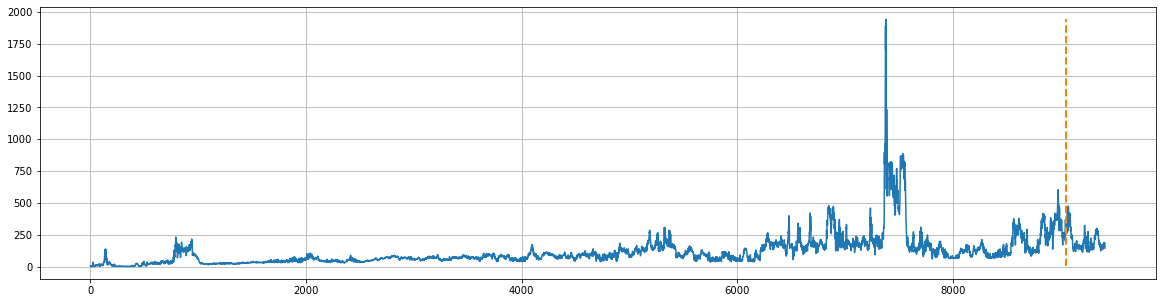

In [222]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(data)
plt.grid()

# linea vertical para dividir el entrenamiento
# del pronóstico
plt.plot([len(data) - 365, len(data) - 365], [min(data), max(data)], "--", linewidth=2);

En la inspeccion visual no se observa un coportamiento ciclico claro lo cual se confirma con el grafico de ACF

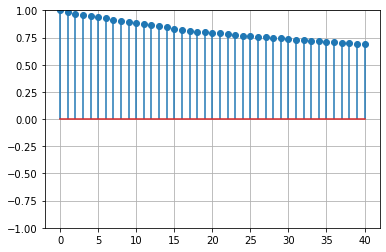

In [223]:


from statsmodels.tsa.stattools import acf, pacf


def acf_plot(z):
    acf_data = acf(z, fft=False)
    plt.stem(range(len(acf_data)), acf_data, use_line_collection=True)
    plt.ylim(-1, 1),
    plt.grid()


def pacf_plot(z):
    pacf_data = pacf(z)
    plt.stem(range(len(pacf_data)), pacf_data, use_line_collection=True)
    plt.ylim(-1, 1)
    plt.grid()


acf_plot(data)

## Transformacion de la serie de tiempo

Se eliminan las componentes de la serie, para con un enfoque que en el rendimiento del modelo

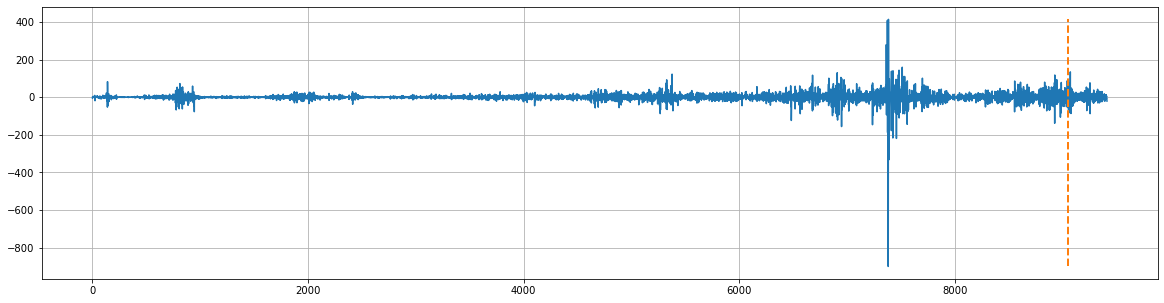

In [224]:

#Se remueve la tendencia
data_d1 = [data[t] - data[t - 1] for t in range(1, len(data))]

# En la gráfica queda la componente cíclica
plt.figure(figsize=(20, 5))
plt.plot(data_d1)
plt.grid()
plt.plot(
    [len(data_d1) - 365, len(data_d1) - 365],
    [min(data_d1), max(data_d1)],
    "--",
    linewidth=2,
);

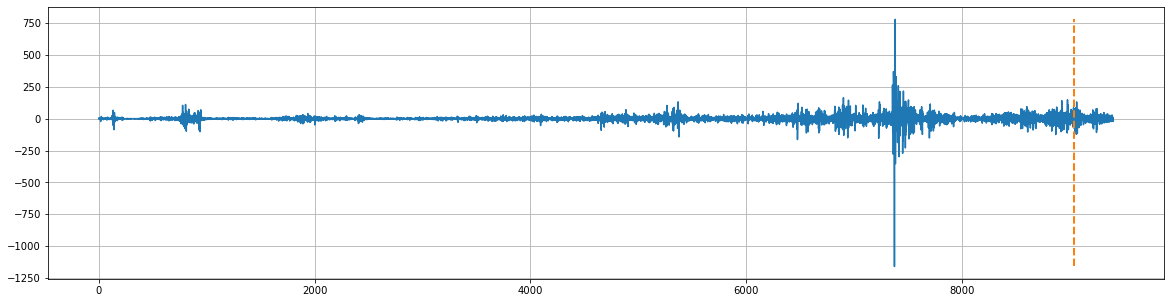

In [225]:
#se remueve la componente ciclica
data_d1d12 = [data_d1[t] - data_d1[t - 7] for t in range(7, len(data_d1))]

plt.figure(figsize=(20, 5))
plt.plot(data_d1d12)
plt.grid()
plt.plot(
    [len(data_d1d12) - 365, len(data_d1d12) - 365],
    [min(data_d1d12), max(data_d1d12)],
    "--",
    linewidth=2,
);

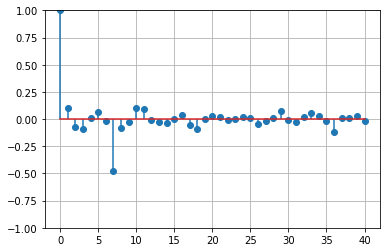

In [226]:
acf_plot(data_d1d12)

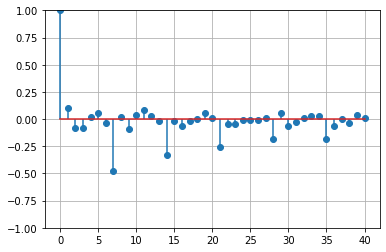

In [227]:
pacf_plot(data_d1d12)

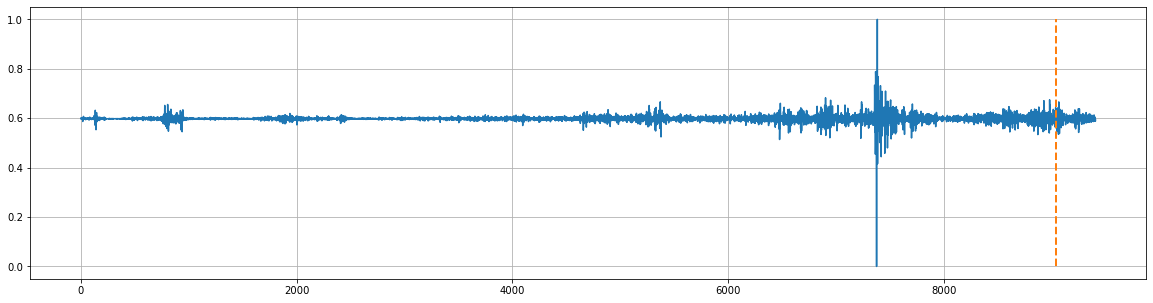

In [228]:
scaler = MinMaxScaler()
data_d1d12_scaled = scaler.fit_transform(np.array(data_d1d12).reshape(-1, 1))
data_d1d12_scaled = [u[0] for u in data_d1d12_scaled]

#
# Se verifica visualmente el escalamiento
#
plt.figure(figsize=(20, 5))
plt.plot(data_d1d12_scaled)
plt.grid()
plt.plot(
    [len(data_d1d12_scaled) - 365, len(data_d1d12_scaled) - 365],
    [min(data_d1d12_scaled), max(data_d1d12_scaled)],
    "--",
    linewidth=2,
);

In [229]:
len(data_d1d12_scaled)

9405

In [230]:
P = 7

X = []
for t in range(P - 1, len(data_d1d12_scaled) - 1):
    X.append([data_d1d12_scaled[t - n] for n in range(P)])

d = data_d1d12_scaled[P:]

In [231]:
len(X)

9398

In [232]:
len(d)

9398

## Modelado

Se entrena la red neuronal y se hace el pronostico para train y test

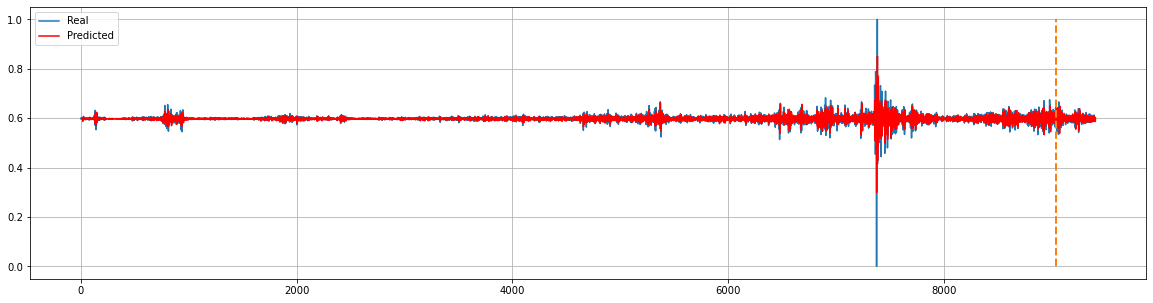

In [233]:
H = 5  # Se escoge arbitrariamente

np.random.seed(123456)

mlp = MLPRegressor(
    hidden_layer_sizes=(H,),
    activation="tanh",
    learning_rate="adaptive",
    momentum=0.0,
    learning_rate_init=0.002,
    max_iter=100000,
)

# Entrenamiento
mlp.fit(X[0:8675], data_d1d12_scaled[0:8675])  # 9405 - 730 = 8675

# Pronostico
y_d1d12_scaled_m2 = mlp.predict(X)


plt.figure(figsize=(20, 5))
plt.plot(data_d1d12_scaled,label='Real')
plt.grid()
#plt.xlim(len(X)-365*2, len(X))

# No hay pronóstico para los primeros 7 valores
# de la serie
plt.plot([None] * P + y_d1d12_scaled_m2.tolist(), "-r",label='Predicted')

# linea vertical para dividir el entrenamiento
# del pronóstico
plt.plot(
    [len(data_d1d12_scaled) - 365, len(data_d1d12_scaled) - 365],
    [min(data_d1d12_scaled), max(data_d1d12_scaled)],
    "--",
    linewidth=2, 
)

plt.legend(loc="upper left");

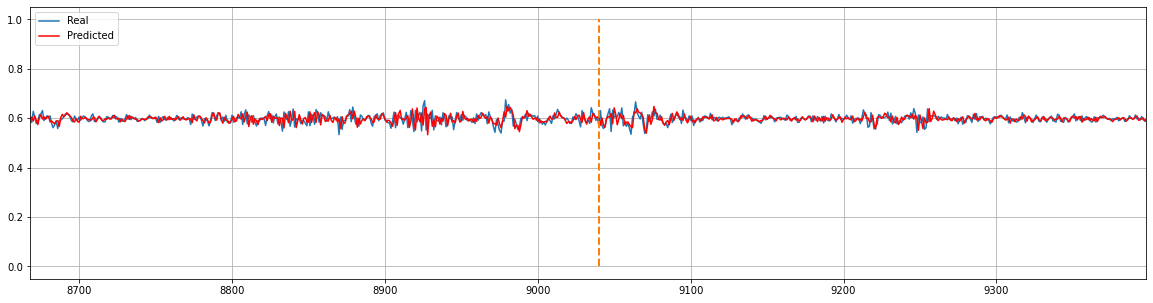

In [234]:
plt.figure(figsize=(20, 5))
plt.plot(data_d1d12_scaled,label='Real')
plt.grid()
plt.xlim(len(X)-365*2, len(X))

# No hay pronóstico para los primeros 7 valores
# de la serie
plt.plot([None] * P + y_d1d12_scaled_m2.tolist(), "-r",label='Predicted')

# linea vertical para dividir el entrenamiento
# del pronóstico
plt.plot(
    [len(data_d1d12_scaled) - 365, len(data_d1d12_scaled) - 365],
    [min(data_d1d12_scaled), max(data_d1d12_scaled)],
    "--",
    linewidth=2,
)

plt.legend(loc="upper left");

In [235]:
print(len(y_d1d12_scaled_m2), ",", len(data_d1d12_scaled) - P)

9398 , 9398


In [236]:
len(data_d1d12_scaled[0:P] + y_d1d12_scaled_m2.tolist())

9405

In [237]:
y_d1d12_scaled_m2 = data_d1d12_scaled[0:P] + y_d1d12_scaled_m2.tolist() #Agrega el periodo que se quito

y_d1d12_m2 = scaler.inverse_transform([[u] for u in y_d1d12_scaled_m2]) #Escalado
y_d1d12_m2 = [u[0] for u in y_d1d12_m2.tolist()]                       

y_d1_m2 = [y_d1d12_m2[t] + data_d1[t] for t in range(len(y_d1d12_m2))] #Agregar componente ciclica
y_d1_m2 = data_d1[0:P] + y_d1_m2

y_m2 = [y_d1_m2[t] + data[t] for t in range(len(y_d1_m2))]  #Agregar tendencia

y_m2 = [data[0]] + y_m2

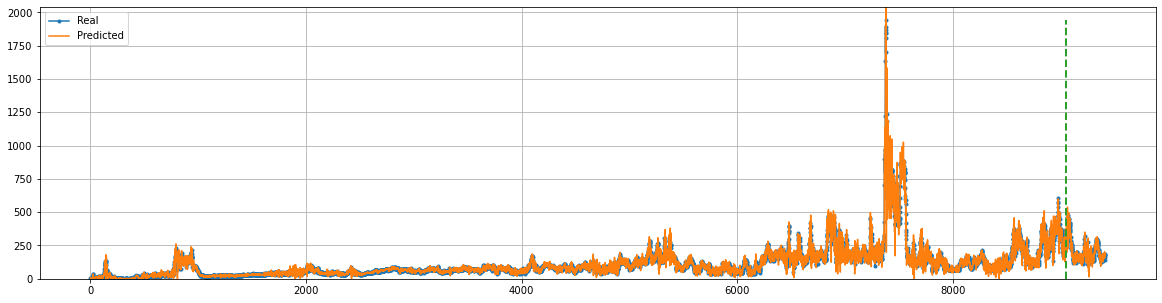

In [238]:
plt.figure(figsize=(20, 5))
plt.plot(data,'.-',label='Real')
plt.grid()
#plt.xlim(len(X)-365*2, len(X))
plt.ylim(0, )
plt.plot(y_m2,label='Predicted')

# linea vertical para dividir el entrenamiento
# del pronóstico. Se ubica en el ultimo dato
# usando para entrenamiento
plt.plot([len(data) - 365, len(data) - 365], [min(data), max(data)], "--", linewidth=2,)
plt.legend(loc="upper left");

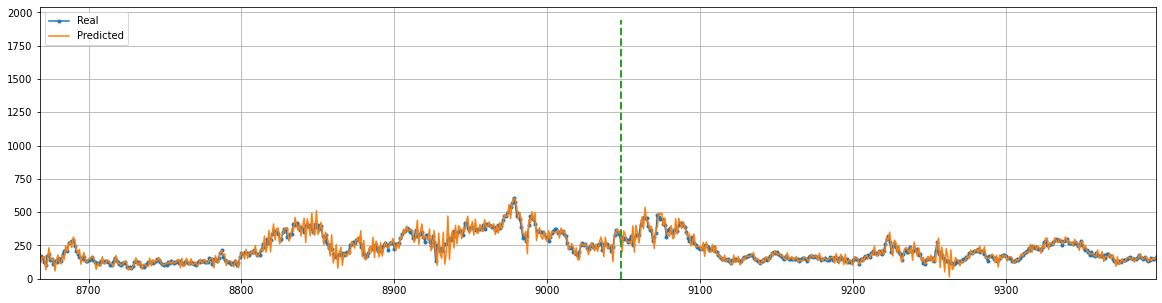

In [239]:
plt.figure(figsize=(20, 5))
plt.plot(data,'.-',label='Real')
plt.grid()
plt.xlim(len(X)-365*2, len(X))
plt.ylim(0, )
plt.plot(y_m2,label='Predicted')

# linea vertical para dividir el entrenamiento
# del pronóstico. Se ubica en el ultimo dato
# usando para entrenamiento
plt.plot([len(data) - 365, len(data) - 365], [min(data), max(data)], "--", linewidth=2,)
plt.legend(loc="upper left");